# Load and preprocess images

## Setup

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

## Download the flowers dataset

이 데이터셋은 꽃의 사진이 수천장 담겨 있습니다. 꽃 데이터 세트에는 클래스당 하나씩 5개의 하위 디렉토리가 있습니다.

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)

data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 2s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


다운로드 후(218MB) 이제 꽃 사진 사본을 사용할 수 있습니다. 총 3,670개의 이미지가 있습니다:

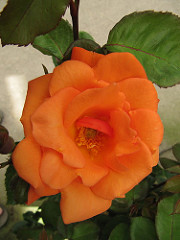

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

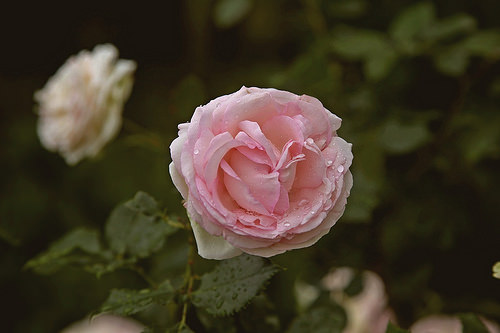

In [53]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## Create a dataset

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

다음은 훈련 데이터 세트의 처음 9개 이미지입니다.

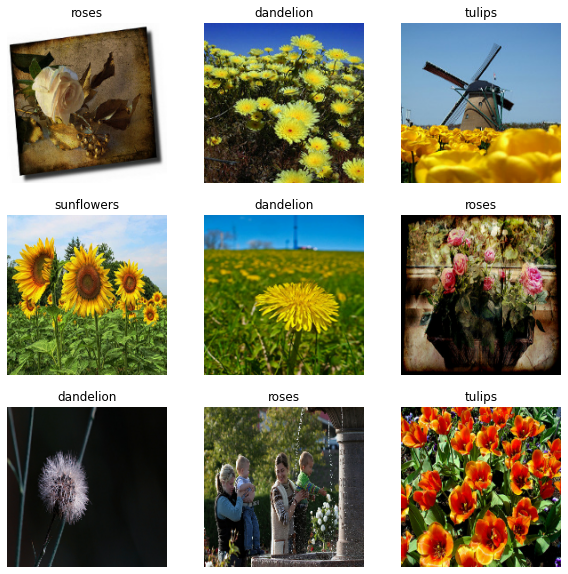

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

이러한 데이터 세트를 에 전달하여 모델을 훈련할 수 있습니다 model.fit 원하는 경우 데이터 세트를 수동으로 반복하고 이미지 배치를 검색할 수도 있습니다.

## Standardize the data

RGB 채널 값이 [0, 255]범위 내에 있습니다. 이것은 신경망에 이상적이지 않습니다. 일반적으로 입력 값을 작게 만들어야 합니다. 여기에서는 레이어 [0, 1]를 사용하여 범위 내에 있는 값을 표준화합니다 tf.keras.layers.experimental.preprocessing.Rescaling.

In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

이 레이어를 사용하는 방법에는 두 가지가 있습니다. map을 호출하여 데이터 세트에 적용할 수 있습니다.

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Configure the dataset for performance

I/O가 차단되지 않고 디스크에서 데이터를 생성할 수 있도록 버퍼링된 프리페치를 사용하도록 합시다. 데이터를 로드할 때 사용해야 하는 두 가지 중요한 방법입니다.

.cache()첫 번째 에포크 동안 디스크에서 로드된 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터 세트가 병목 현상이 되지 않습니다. 데이터 세트가 너무 커서 메모리에 맞지 않는 경우 이 방법을 사용하여 고성능 디스크 캐시를 생성할 수도 있습니다.

.prefetch() 훈련하는 동안 데이터 전처리와 모델 실행이 겹칩니다.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Train a model

In [ ]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
92/92 [==============================] - 38s 92ms/step - loss: 1.3060 - accuracy: 0.4142 - val_loss: 1.0944 - val_accuracy: 0.5804
Epoch 2/10
92/92 [==============================] - 4s 45ms/step - loss: 1.0357 - accuracy: 0.5848 - val_loss: 1.0797 - val_accuracy: 0.5817
Epoch 3/10
92/92 [==============================] - 4s 45ms/step - loss: 0.8941 - accuracy: 0.6485 - val_loss: 1.0144 - val_accuracy: 0.5804
Epoch 4/10
92/92 [==============================] - 4s 46ms/step - loss: 0.7355 - accuracy: 0.7139 - val_loss: 1.0168 - val_accuracy: 0.6213
Epoch 5/10
92/92 [==============================] - 4s 45ms/step - loss: 0.5716 - accuracy: 0.7807 - val_loss: 0.9833 - val_accuracy: 0.6362
Epoch 6/10
92/92 [==============================] - 4s 45ms/step - loss: 0.4761 - accuracy: 0.8236 - val_loss: 1.0367 - val_accuracy: 0.6458
Epoch 7/10
92/92 [==============================] - 4s 44ms/step - loss: 0.4120 - accuracy: 0.8515 - val_loss: 1.2454 - val_accuracy: 0.6199
Epoch 8/10
9

## Using tf.data for finer control

위의 tf.keras.preprocessing유틸리티는 tf.data.Dataset이미지 디렉토리에서 생성하는 편리한 방법 입니다. 더 세밀한 제어를 위해 를 사용하여 고유한 입력 파이프라인을 작성할 수 있습니다 tf.data. 이 섹션에서는 이전에 다운로드한 TGZ 파일의 파일 경로부터 시작하여 이를 수행하는 방법을 보여줍니다.

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/roses/2093263381_afd51358a3.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/20456824132_b1c8fbfa41_m.jpg'
b'/root/.keras/datasets/flower_photos/tulips/6936168062_a31c28b77c_m.jpg'
b'/root/.keras/datasets/flower_photos/tulips/16303377824_6e9128b4bd.jpg'
b'/root/.keras/datasets/flower_photos/tulips/3282751630_45c2665034_m.jpg'


In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name!= 'LICENSE.txt']))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [ ]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


파일 경로를 (img, label)쌍으로 변환하는 짧은 함수를 작성하십시오 .

In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2


성능을 위한 데이터세트 구성
이 데이터 세트로 모델을 훈련하려면 다음 데이터가 필요합니다.

잘 섞이도록.
일괄 처리됩니다.
가능한 한 빨리 배치를 사용할 수 있습니다.
이러한 기능은 tf.dataAPI를 사용하여 추가할 수 있습니다 . 자세한 내용은 입력 파이프라인 성능 가이드를 참조하세요 .

In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## Visualize the data

이전에 생성한 데이터 세트와 유사하게 이 데이터 세트를 시각화할 수 있습니다.

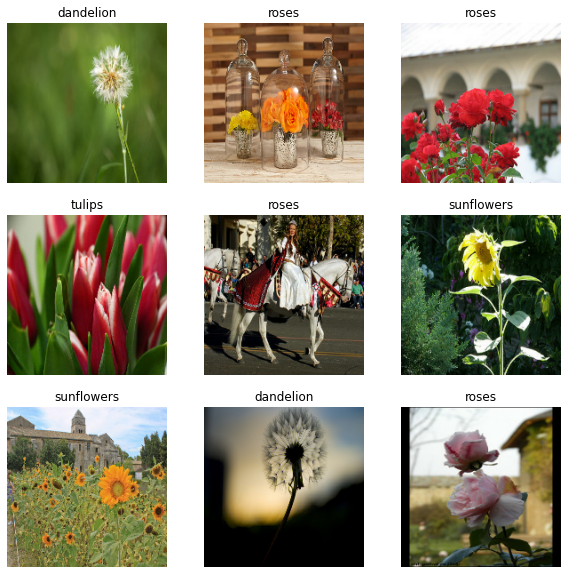

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## Continue training the model


In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 10s 93ms/step - loss: 0.3598 - accuracy: 0.8968 - val_loss: 0.3160 - val_accuracy: 0.9101
Epoch 2/3
92/92 [==============================] - 4s 49ms/step - loss: 0.1393 - accuracy: 0.9544 - val_loss: 0.3324 - val_accuracy: 0.9101
Epoch 3/3
92/92 [==============================] - 5s 49ms/step - loss: 0.0491 - accuracy: 0.9884 - val_loss: 0.4333 - val_accuracy: 0.9060


## Using TensorFlow Datasets

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


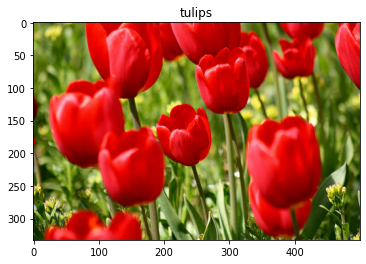

In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [ ]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)